In [ ]:
"""
Use all variables (continuous, categorical) as features

Baseline models:

1. Logistic Regression
2. kNN
3. Naive Bayes

Conclusion:
ROC AUC highest - Logistic regression
Recall highest - Naive Bayes (64%)

"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Load data
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')

In [3]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,25.0,50-99,unknown,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5,47,0
2,11561,city_21,0.624,unknown,No relevent experience,Full time course,Graduate,STEM,5.0,50-99,unknown,0,83,0
3,33241,city_115,0.789,unknown,No relevent experience,unknown,Graduate,Business Degree,0.5,50-99,Pvt Ltd,0,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,25.0,50-99,Funded Startup,4,8,0


## Treat continuous and categorical variables separately and then combine

In [28]:
# Continuous variables
features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']
X_train_con = df_train[features]


# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(df_train[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)

y_train = df_train['target']

In [5]:
# Categorical variables
cat_variables = ['relevent_experience','enrolled_university','education_level','major_discipline','company_size','company_type']
X_train_cat = df_train[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)

In [31]:
# Combine Con and Cat
X_train = pd.concat([X_train_con_df,X_train_cat_df], axis='columns')

In [32]:
X_train

,city_development_index,training_hours,experience,last_new_job,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,enrolled_university_unknown,education_level_High School,education_level_Masters,...,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown
0,0.738919,-0.488985,1.793483,-0.588135,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.428410,-0.305825,0.530812,1.816493,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.660590,0.293607,-0.731859,-1.189292,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.323026,-0.222571,-1.300061,-1.189292,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.501368,-0.955209,1.793483,1.215336,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.398448,-0.389079,0.404545,-0.588135,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19154,0.738919,-0.222571,0.404545,1.215336,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19155,0.738919,-0.355778,1.793483,1.215336,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19156,-0.217642,0.526719,-1.300061,0.013022,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
# Repeat for test set

y_test = df_test['target']

# Continuous variables
features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']
X_test_con = df_test[features]


# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(df_test[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

y_test = df_test['target']

# Categorical variables
cat_variables = ['relevent_experience','enrolled_university','education_level','major_discipline','company_size','company_type']
X_test_cat = df_test[cat_variables]

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_test_cat) 
cats = ohe.transform(X_test_cat)

columns = ohe.get_feature_names(cat_variables)
X_test_cat_df = pd.DataFrame(cats, columns=columns, index=X_test_cat.index)

# Combine Con and Cat
X_test = pd.concat([X_test_con_df,X_test_cat_df], axis='columns')

In [34]:
X_test

,city_development_index,training_hours,experience,last_new_job,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,enrolled_university_unknown,education_level_High School,education_level_Masters,...,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown
0,0.016126,-0.730319,-0.228668,-0.606057,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.759860,0.548230,-0.725944,-0.606057,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.607295,-0.829946,-1.285380,-1.214974,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.016126,-0.431437,0.019970,-0.606057,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.759860,0.116513,1.760438,1.829611,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,0.759860,-0.829946,0.641566,1.220694,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2125,0.575926,-0.580878,0.890204,0.002860,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2126,0.495955,-0.780132,-0.974583,-1.214974,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2127,-0.167809,0.315767,-0.477306,-0.606057,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Pickle

In [35]:
X_train.to_pickle('../dump/X_train_processed')
X_test.to_pickle('../dump/X_test_processed')

### 1. Logistic Regression

In [36]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(cat_variables,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  -1.0068


,Feature,Coef
4,company_size,[0.24928979865438497]
3,major_discipline,[0.10408129961586973]
1,enrolled_university,[-0.05287268836603191]
2,education_level,[-0.16071169129610408]
5,company_type,[-0.23556693616526303]
0,relevent_experience,[-0.7080709116021694]


In [37]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1447,106
Changing (1),429,147


In [38]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Looking', 'Looking'],
           yticklabels=['Not Looking', 'Looking']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [39]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [40]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.7487083137623297 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1553
           1       0.58      0.26      0.35       576

    accuracy                           0.75      2129
   macro avg       0.68      0.59      0.60      2129
weighted avg       0.72      0.75      0.71      2129



In [41]:
df_test['proba_change'] = lm.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['target'],
                                 df_test['proba_change'])

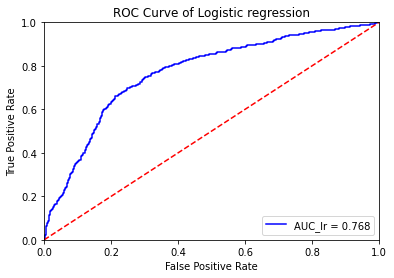

In [42]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.show()

### 2. KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=3):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7303898543917332 

Classification report (kNN, n=3):

               precision    recall  f1-score   support

           0       0.79      0.86      0.82      1553
           1       0.50      0.37      0.43       576

    accuracy                           0.73      2129
   macro avg       0.65      0.62      0.63      2129
weighted avg       0.71      0.73      0.72      2129



In [44]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train,y_train)
pred = knn_5.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=5):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7388445279473932 

Classification report (kNN, n=5):

               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1553
           1       0.52      0.38      0.44       576

    accuracy                           0.74      2129
   macro avg       0.66      0.63      0.63      2129
weighted avg       0.72      0.74      0.72      2129



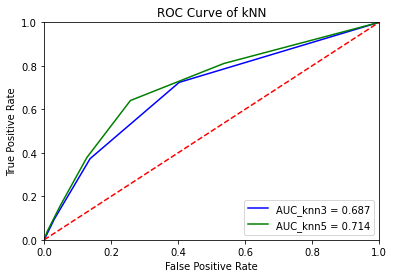

In [45]:
# knn (n=3)
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_knn3 = %0.3f' % roc_auc)

# knn (n=5)
y_scores = knn_5.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC_knn5 = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

### 3. Naive Bayes

In [46]:
nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6636918741193049 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.83      0.67      0.75      1553
           1       0.42      0.64      0.51       576

    accuracy                           0.66      2129
   macro avg       0.63      0.66      0.63      2129
weighted avg       0.72      0.66      0.68      2129



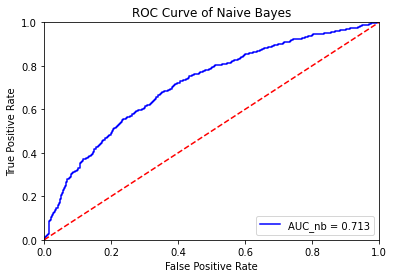

In [47]:
# Naive Bayes ROC curve
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Naive Bayes')
plt.show()

In [23]:
# Naive Bayes model has higher recall!